import data 

In [246]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt

os.chdir("/Users/jacobrichards/Desktop/Personal_save/Python")

transactions = pd.read_csv("transactions.csv", na_values=["", "NA"])

display(transactions.head())

,t,success,mid,pmt,pg,sub_type,hr,bank
0,2,1,zivame,NB,PAYU,NaN,2020-02-14 06,NB_CITI
1,1,0,urbanclap,NB,PAYTM,NaN,2020-02-14 06,NB_SYNB
2,5,1,pharmeasytech,WALLET,AIRTELMONEY,REDIRECT_WALLET_DEBIT,2020-02-14 11,AIRTELMONEY
3,1,1,pharmeasytech,CARD,PAYU,NaN,2020-02-14 12,THE SATARA SAHAKARI BANK LTD MUMBAI
4,1,1,fanfight,CARD,RAZORPAY,NaN,2020-02-14 06,DCB


clean data 

In [247]:
#replace NA's with string
transactions.fillna("notprovided", inplace = True)

#change column names
transactions.columns = ["t", "s", "mid", "pmt", "pg", "subtype", "hr", "bank"]

compute the transaction failure rate for each unique hour within the data set and plot it 

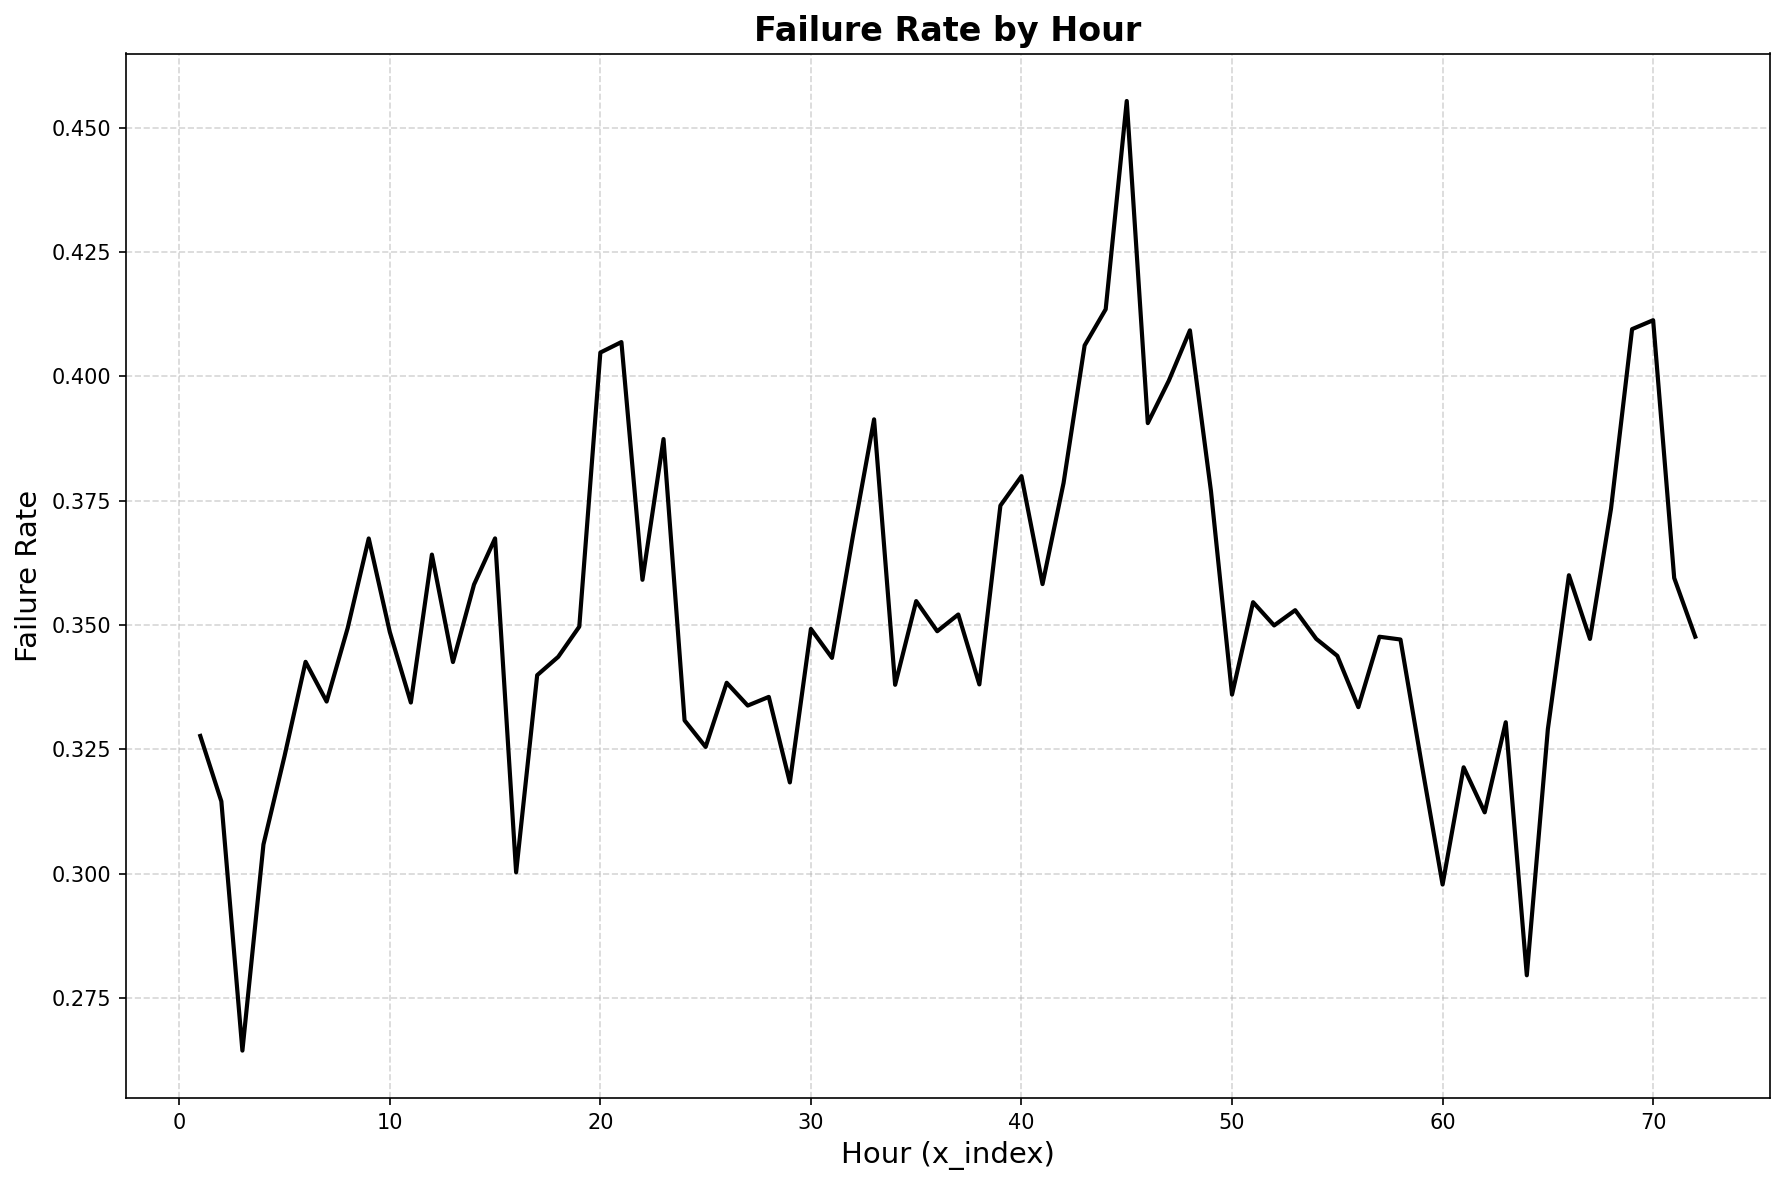

In [248]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_failure_rate(dataframe):
    unique_hours = sorted(dataframe['hr'].unique())

    t_by_hour = dataframe.groupby('hr')['t'].sum()
    s_by_hour = dataframe.groupby('hr')['s'].sum()

    failure_count = t_by_hour - s_by_hour
    failure_rate = failure_count / t_by_hour

    plot_data = pd.DataFrame({
        'hours': unique_hours,
        'failure_rate': failure_rate.values,
        'x_index': np.arange(1, len(unique_hours) + 1)
    })

    # High-quality settings
    plt.figure(figsize=(12, 8), dpi=150)  # Larger size and higher DPI
    plt.plot(
        plot_data['x_index'],
        plot_data['failure_rate'],
        color='black',
        linewidth=2,
        antialiased=True  # Enable anti-aliasing for smoother lines
    )
    plt.title("Failure Rate by Hour", fontsize=16, fontweight='bold')  # Larger, bold title
    plt.xlabel("Hour (x_index)", fontsize=14)
    plt.ylabel("Failure Rate", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()  # Ensure no clipping of labels
    plt.show()

plot_failure_rate(transactions)

append transaction failure rate and count of each row of data frame 

In [249]:
transactions['failures'] = transactions['t'] - transactions['s']
transactions['failure_rate'] = (transactions['t'] - transactions['s']) / transactions['t']

plotting the 2d distribution of failed transaction count and transaction failure rate 

In [250]:
import plotly.graph_objects as go
from scipy.stats import gaussian_kde as gaussian_kde

# Perform 2D Kernel Density Estimation (KDE)
x = transactions["t"]
y = transactions["failure_rate"]
kde = gaussian_kde([x, y])

# Create a grid for evaluation
x_grid = np.linspace(x.min(), x.max(), 50)
y_grid = np.linspace(y.min(), y.max(), 50)
x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)
z = kde(np.vstack([x_mesh.ravel(), y_mesh.ravel()])).reshape(x_mesh.shape)

# Create 3D surface plot using Plotly
fig = go.Figure(data=[
    go.Surface(
        x=x_grid, 
        y=y_grid, 
        z=z, 
        colorscale="Viridis", 
        showscale=True
    )
])

# Add labels and title
fig.update_layout(
    title="3D KDE Surface Plot",
    scene=dict(
        xaxis_title="Failures",
        yaxis_title="Failure Rate",
        zaxis_title="Density"
    )
)

# Show the interactive plot
fig.show()


evaluating the Mohalanobis distances method

In [251]:
from scipy.spatial.distance import mahalanobis
from scipy.stats import zscore

features = transactions[['t', 'failure_rate']]

center = features.mean().values # the .values argument produces a list of the column means 

cov_matrix = np.cov(features.T) #covance is calculated from paired observations 

inv_cov_matrix = np.linalg.inv(cov_matrix)
mahalanobis_distances = features.apply(
    lambda row: mahalanobis(row, center, inv_cov_matrix), axis=1
)

transactions["mahalanobis_score"] = mahalanobis_distances

transactions = transactions.sort_values(by="mahalanobis_score", ascending=False)

display(transactions.head(10))

,t,s,mid,pmt,pg,subtype,hr,bank,failures,failure_rate,mahalanobis_score
3871,3365,2524,fanfight,UPI,PAYTM_UPI,UPI_PAY,2020-02-14 15,UPI,841,0.249926,62.800060
4466,3340,2462,fanfight,UPI,PAYTM_UPI,UPI_PAY,2020-02-12 15,UPI,878,0.262874,62.331665
4169,1391,1086,fanfight,UPI,PAYTM_UPI,UPI_PAY,2020-02-12 02,UPI,305,0.219267,25.833265
4133,1357,918,fanfight,UPI,PAYTM_UPI,UPI_PAY,2020-02-14 14,UPI,439,0.323508,25.193931
3943,1258,767,fanfight,UPI,PAYTM_UPI,UPI_PAY,2020-02-12 14,UPI,491,0.390302,23.339856
4888,1230,1001,fanfight,WALLET,PAYTM,DIRECT_WALLET_DEBIT,2020-02-14 15,PAYTM,229,0.186179,22.819975
4969,1197,952,fanfight,WALLET,PAYTM,DIRECT_WALLET_DEBIT,2020-02-12 15,PAYTM,245,0.204678,22.201091
3837,1156,884,fanfight,UPI,PAYTM_UPI,UPI_PAY,2020-02-14 11,UPI,272,0.235294,21.431954
3865,1078,754,fanfight,UPI,PAYTM_UPI,UPI_PAY,2020-02-14 13,UPI,324,0.300557,19.969266
3909,1025,639,fanfight,UPI,PAYTM_UPI,UPI_PAY,2020-02-12 13,UPI,386,0.376585,18.976251


checking the failure rate plot of the categorical variables present in the outlier observations

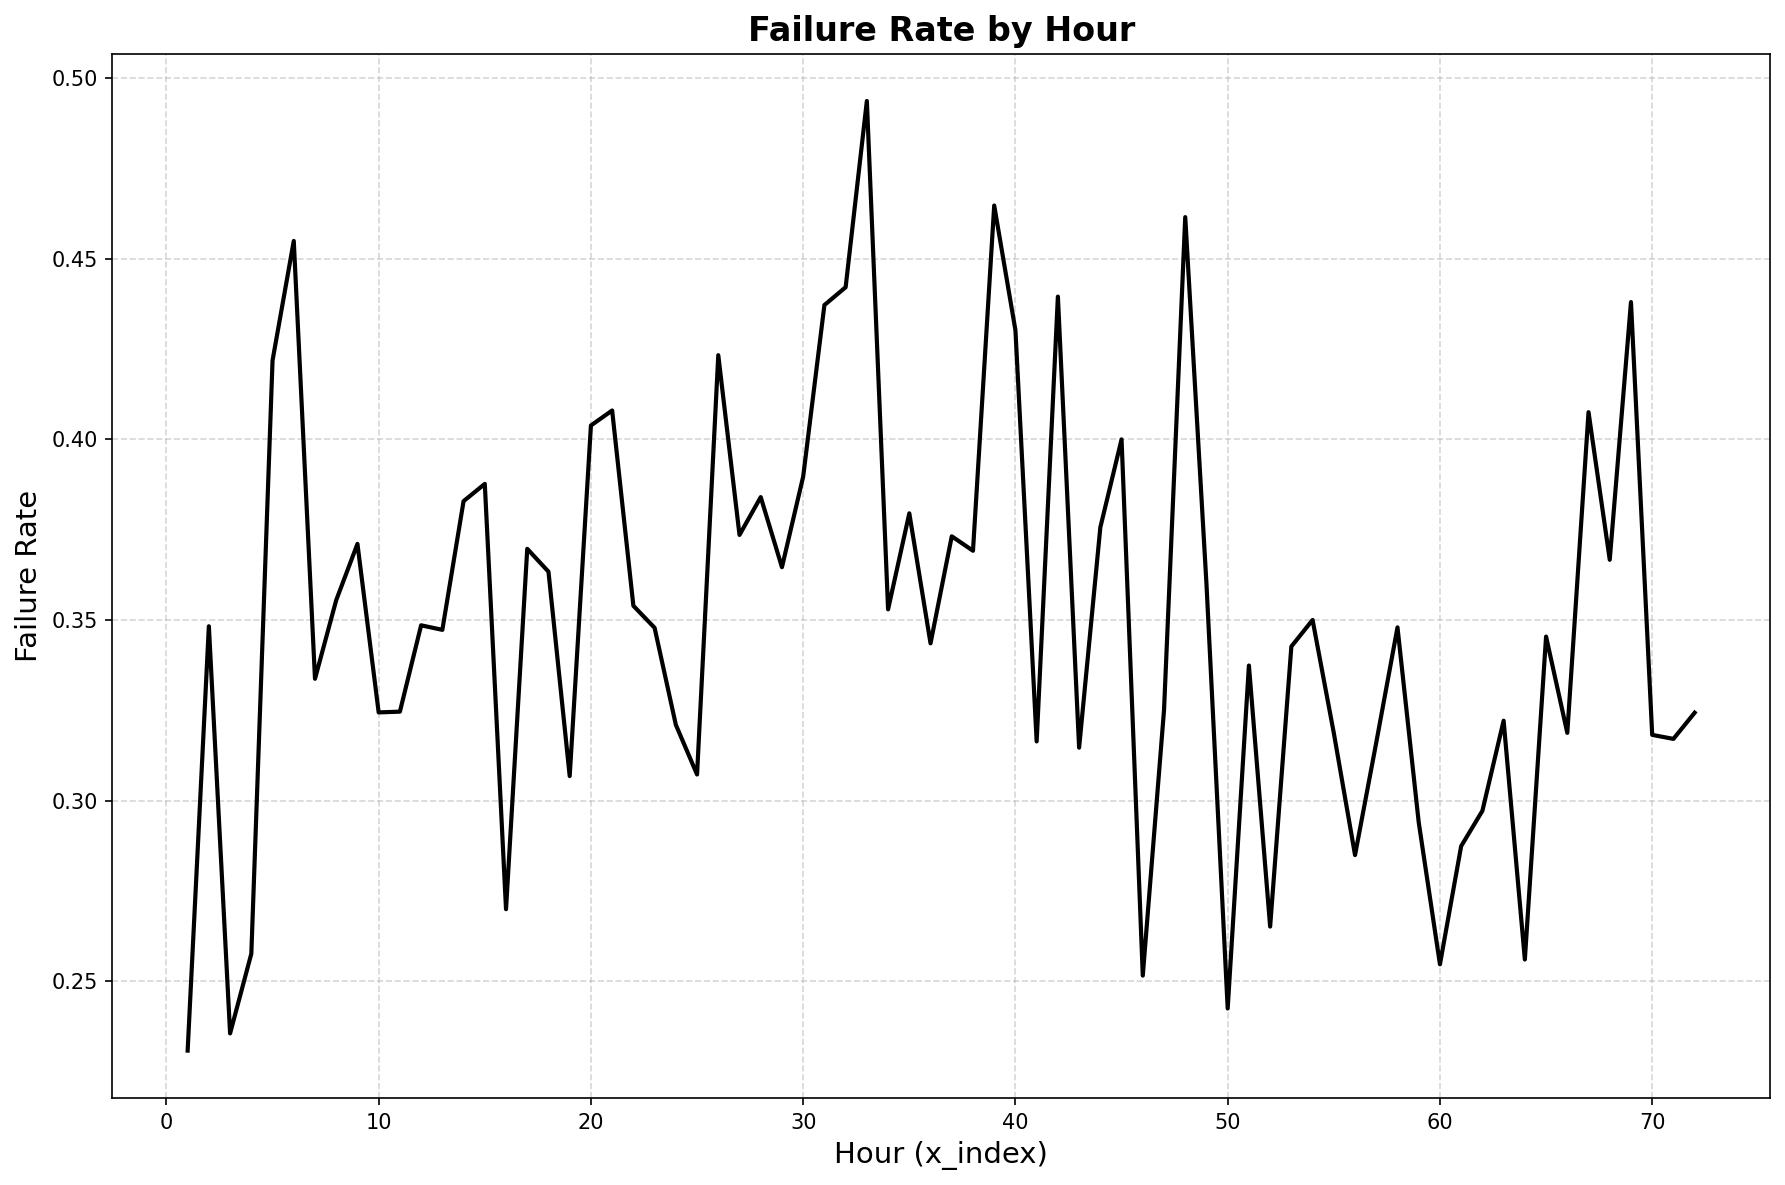

In [252]:
subset = transactions[
    (transactions['pmt'] == 'UPI') & 
    (transactions['pg'].isin(["PAYTM", "PAYTM_V2", "PAYTM_UPI"])) & 
    (transactions['subtype'] == 'UPI_PAY')
]

plot_failure_rate(subset)

ok so that's not the right combination, what about we plot all combiantions of the variables and see if we can sort through it to find what the problem is 

command r is run all
command enter is run the cell

['UPI | PAYTM_V2 | UPI_PAY',
 'UPI | PAYTM_UPI | UPI_PAY',
 'UPI | PAYTM_V2 | UPI_COLLECT',
 'WALLET | PAYTM | DIRECT_WALLET_DEBIT',
 'WALLET | PAYTM | REDIRECT_WALLET_DEBIT',
 'WALLET | PAYTM | notprovided',
 'CARD | PAYTM | notprovided',
 'NB | PAYTM | notprovided']

'Plotting for key: UPI | PAYTM_V2 | UPI_PAY'

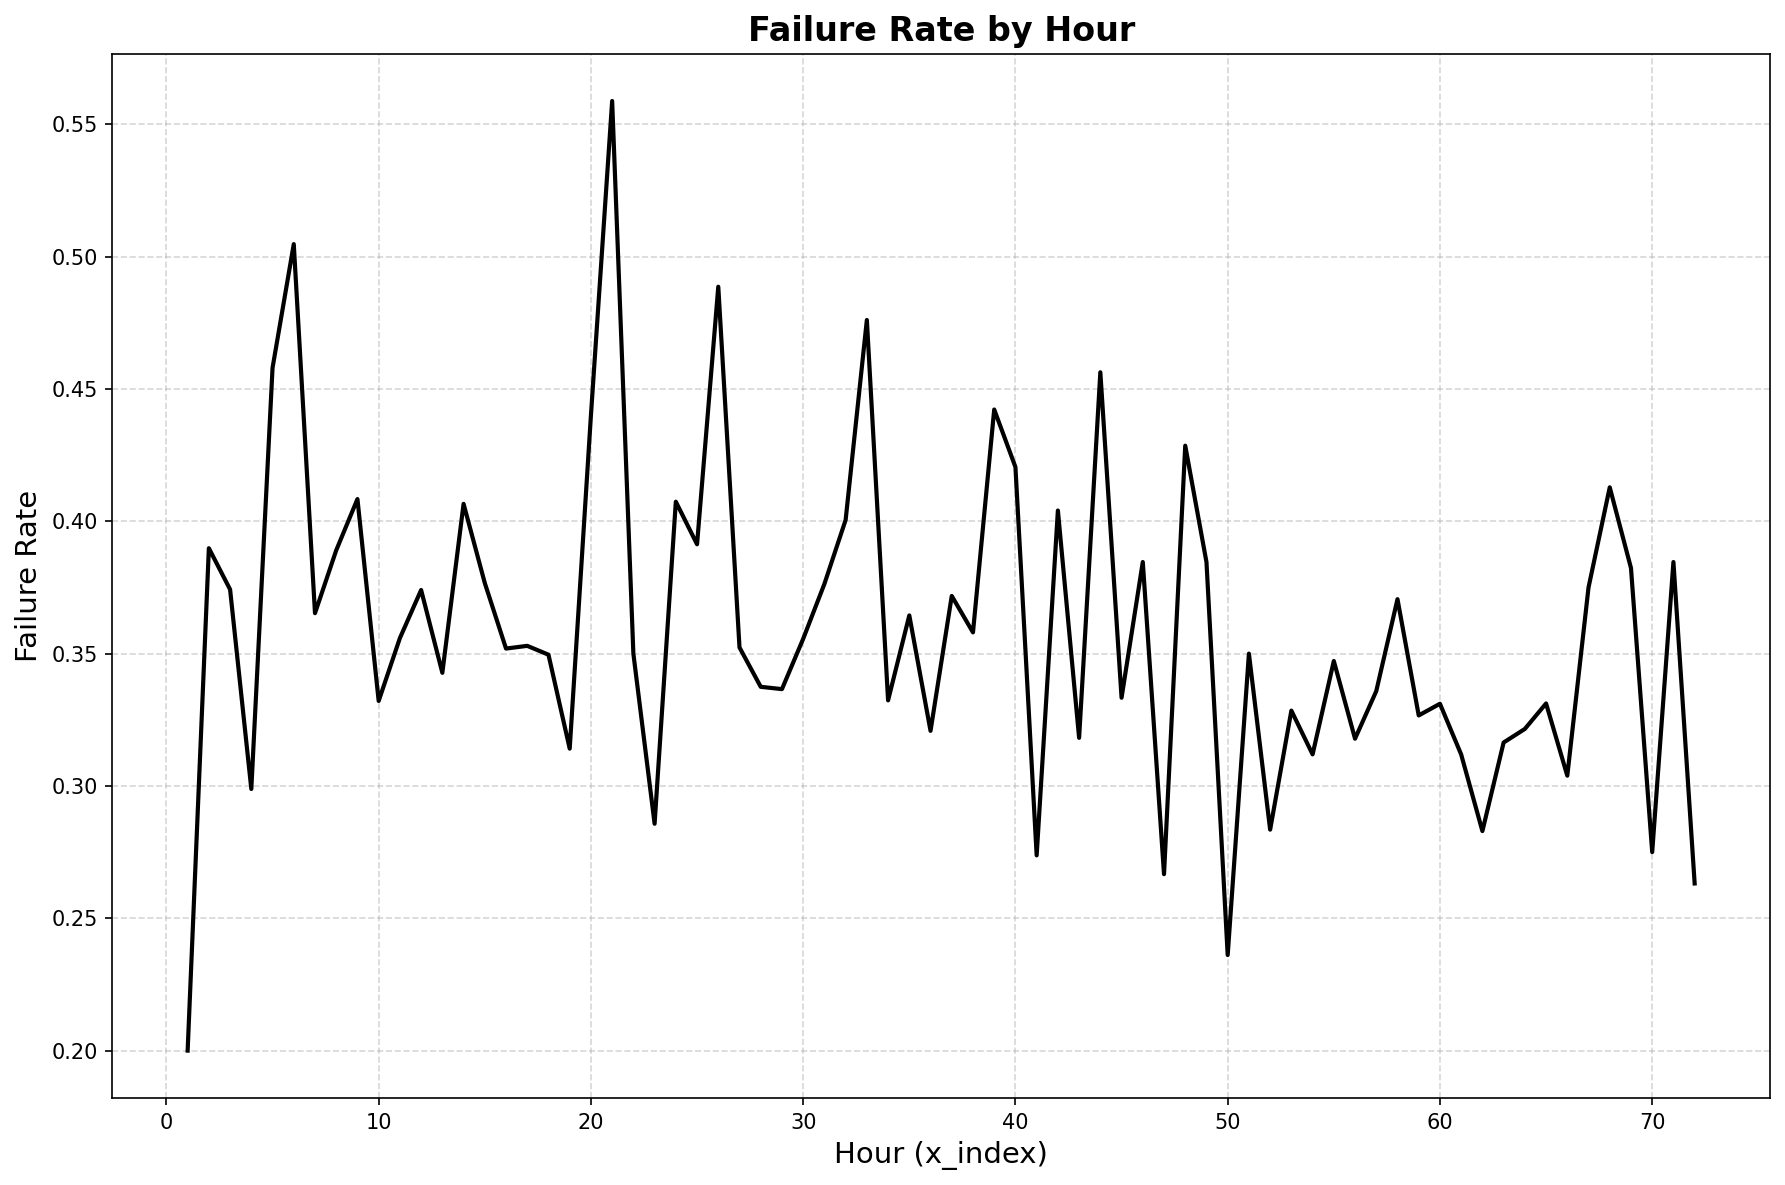

'Plotting for key: UPI | PAYTM_UPI | UPI_PAY'

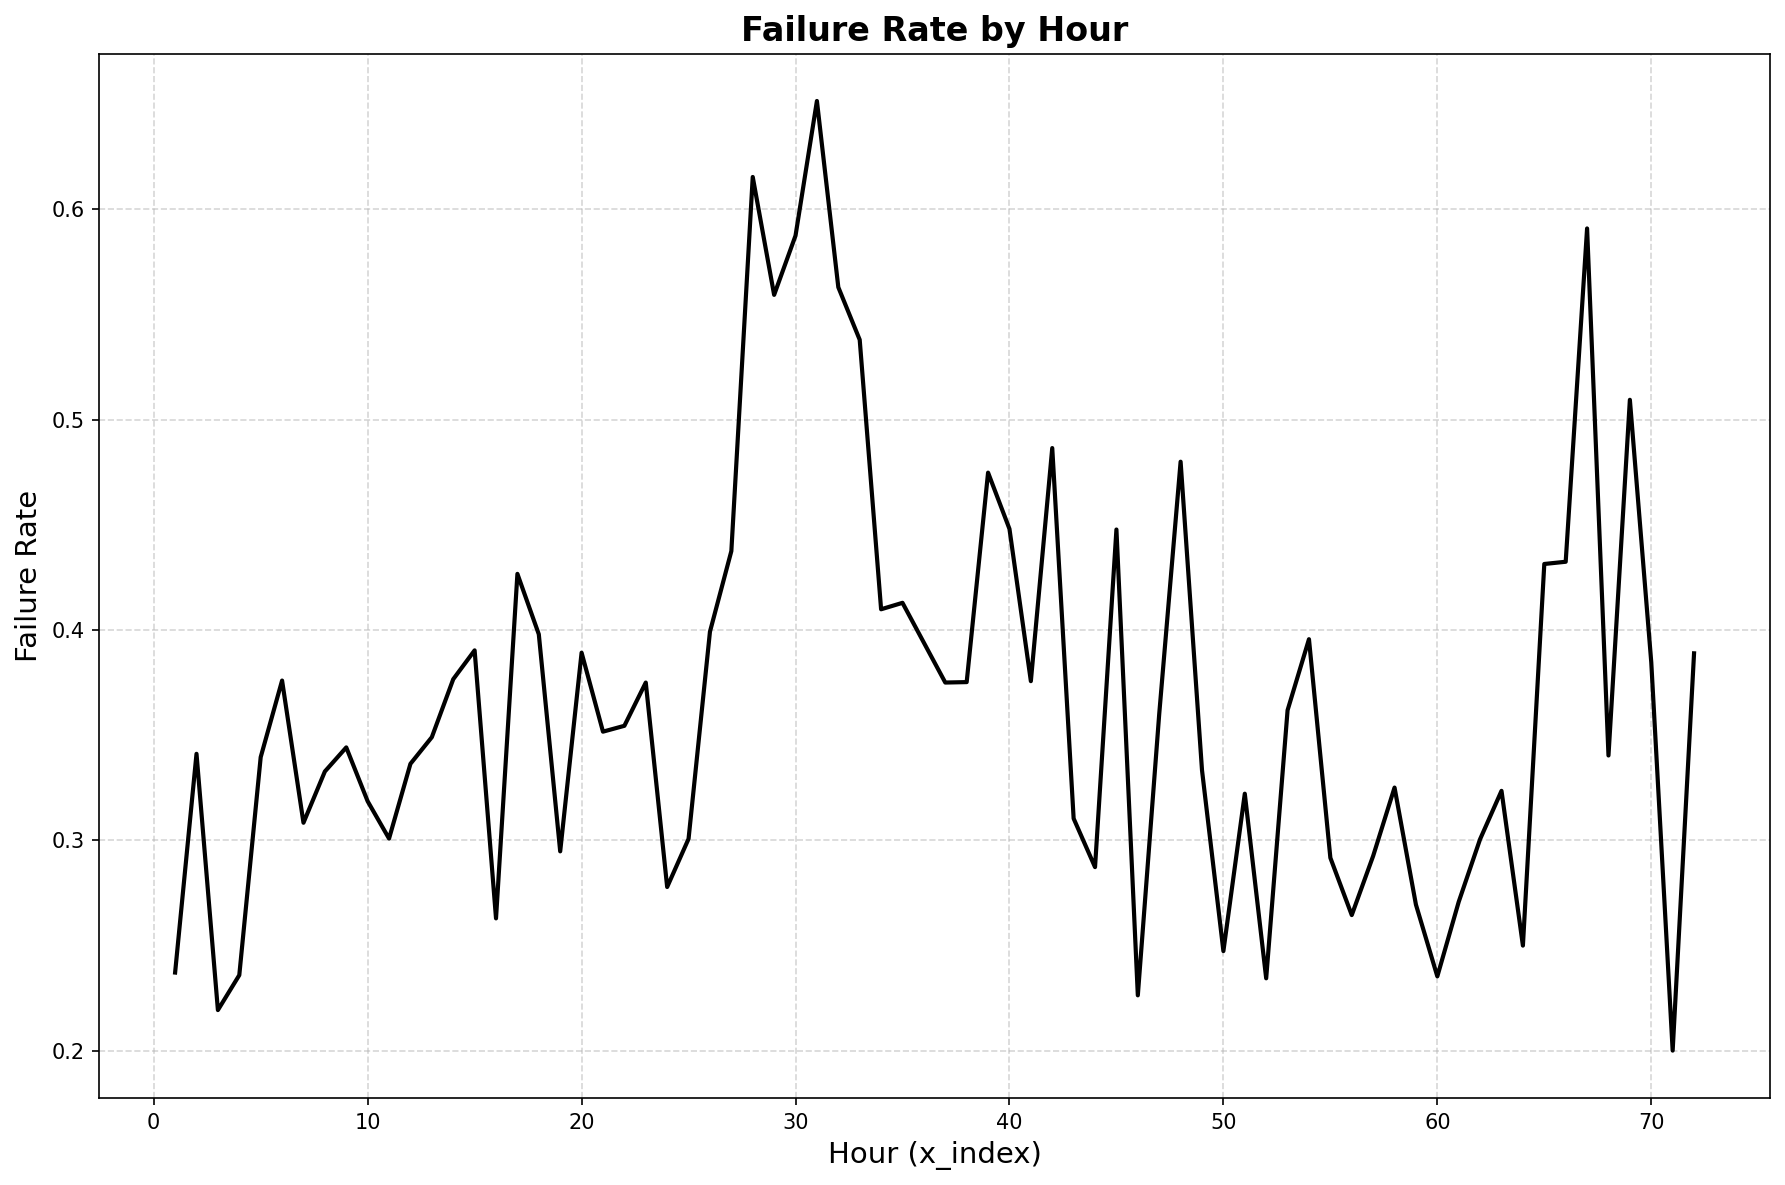

'Plotting for key: UPI | PAYTM_V2 | UPI_COLLECT'

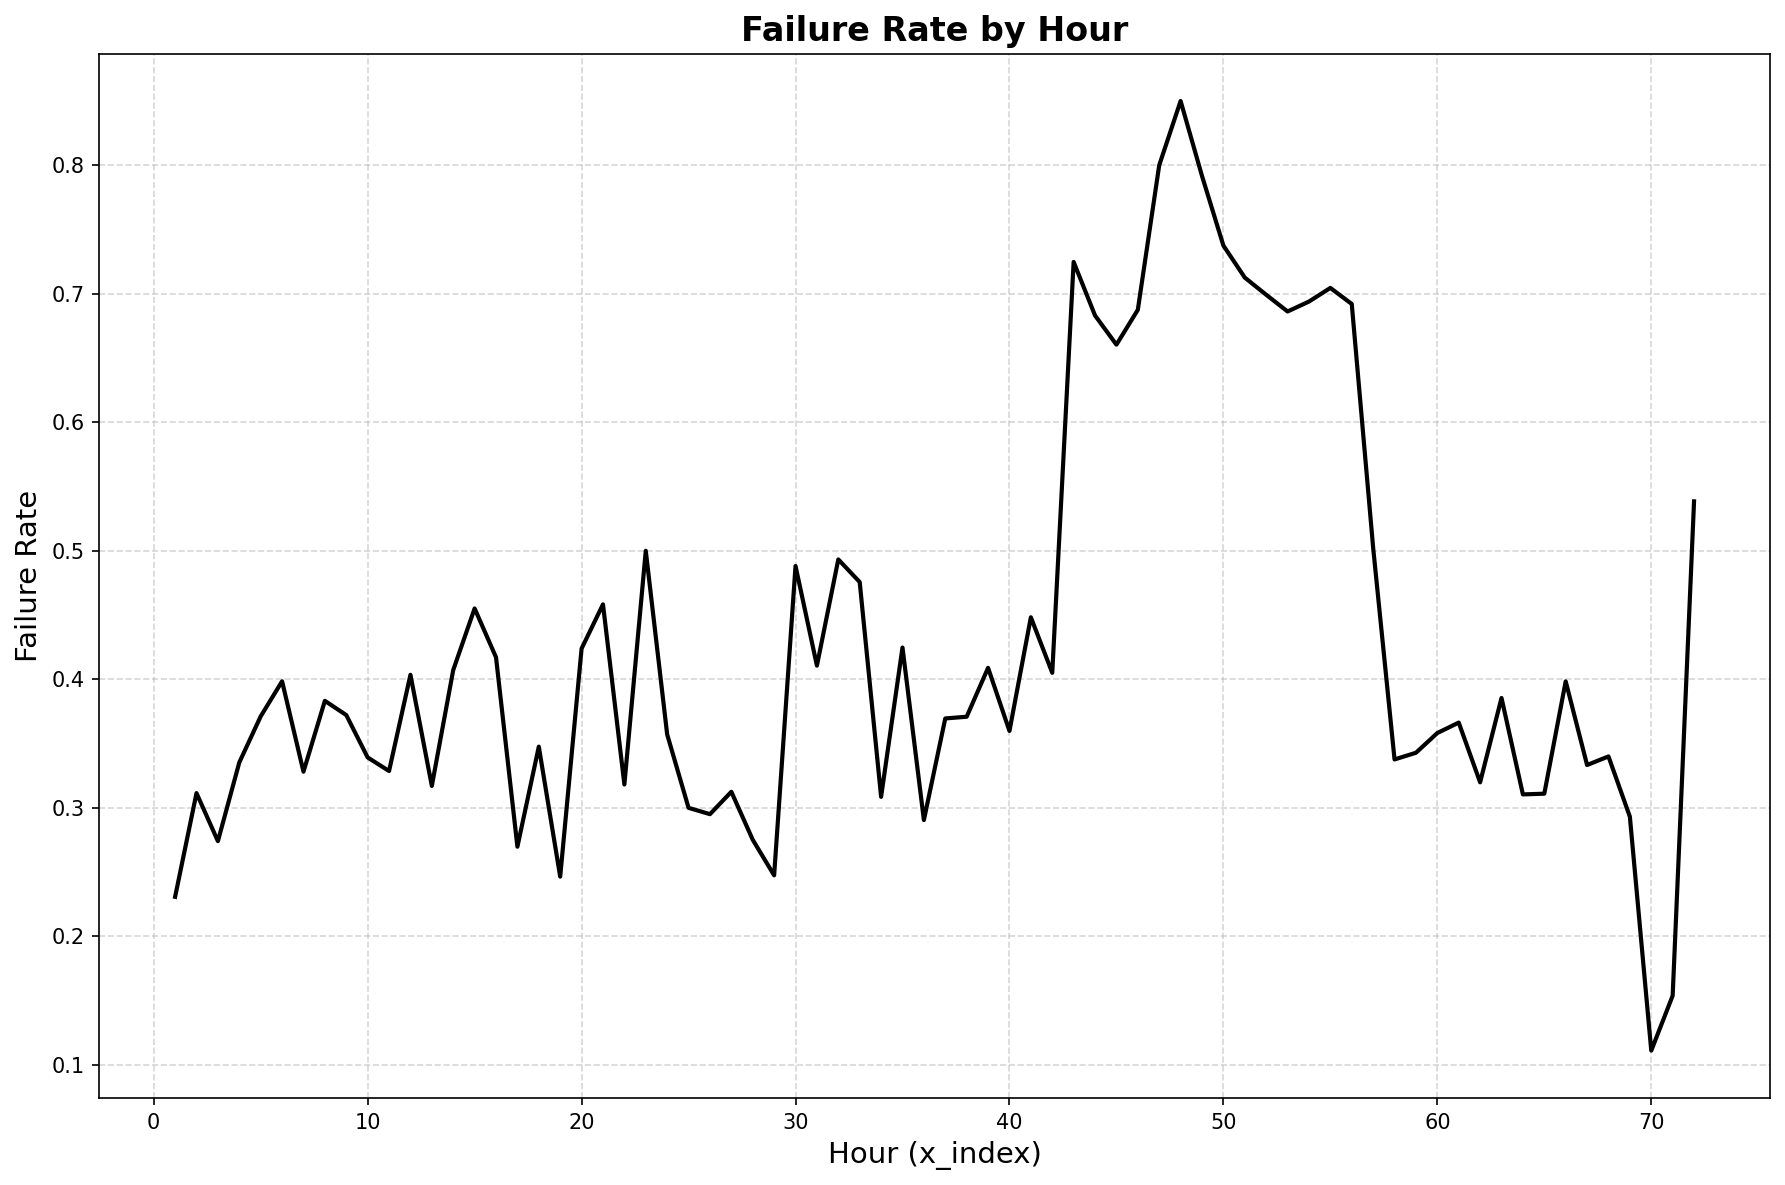

'Plotting for key: WALLET | PAYTM | DIRECT_WALLET_DEBIT'

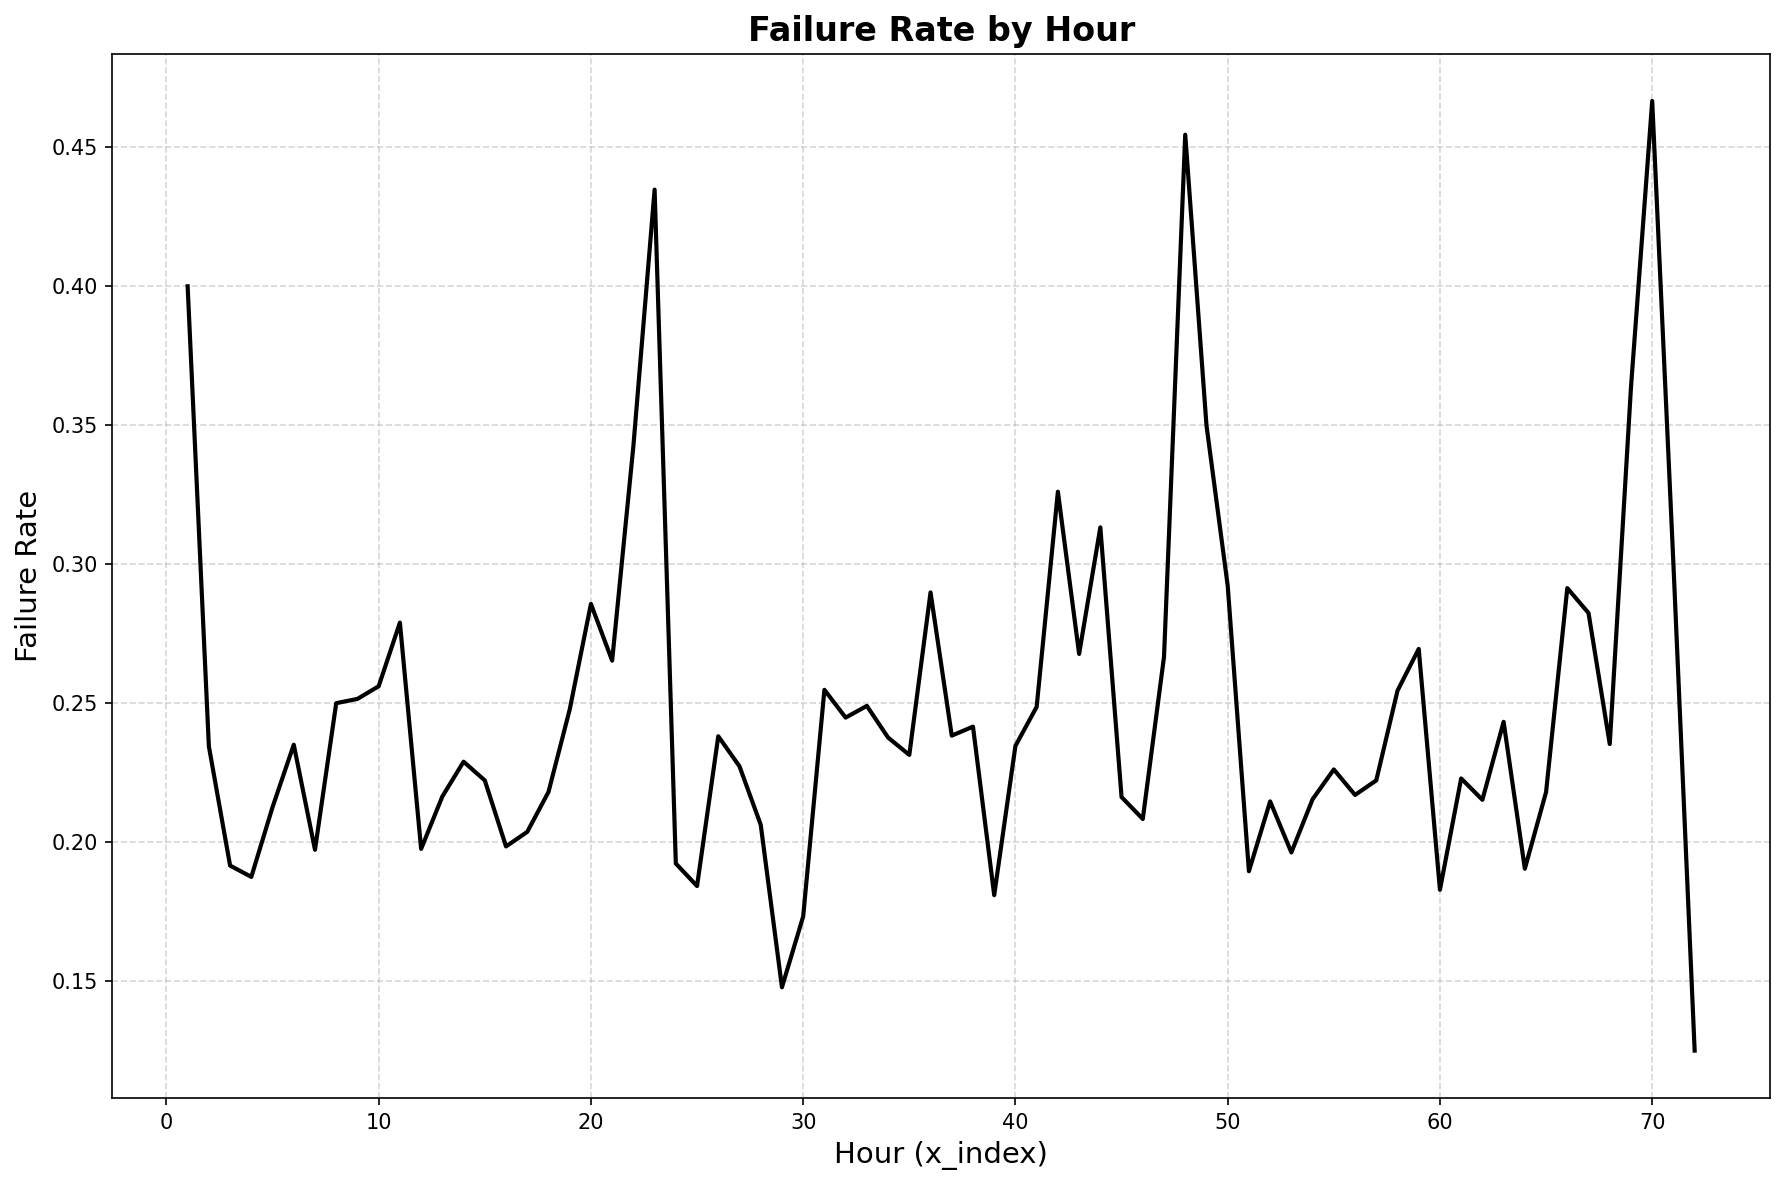

'Plotting for key: WALLET | PAYTM | REDIRECT_WALLET_DEBIT'

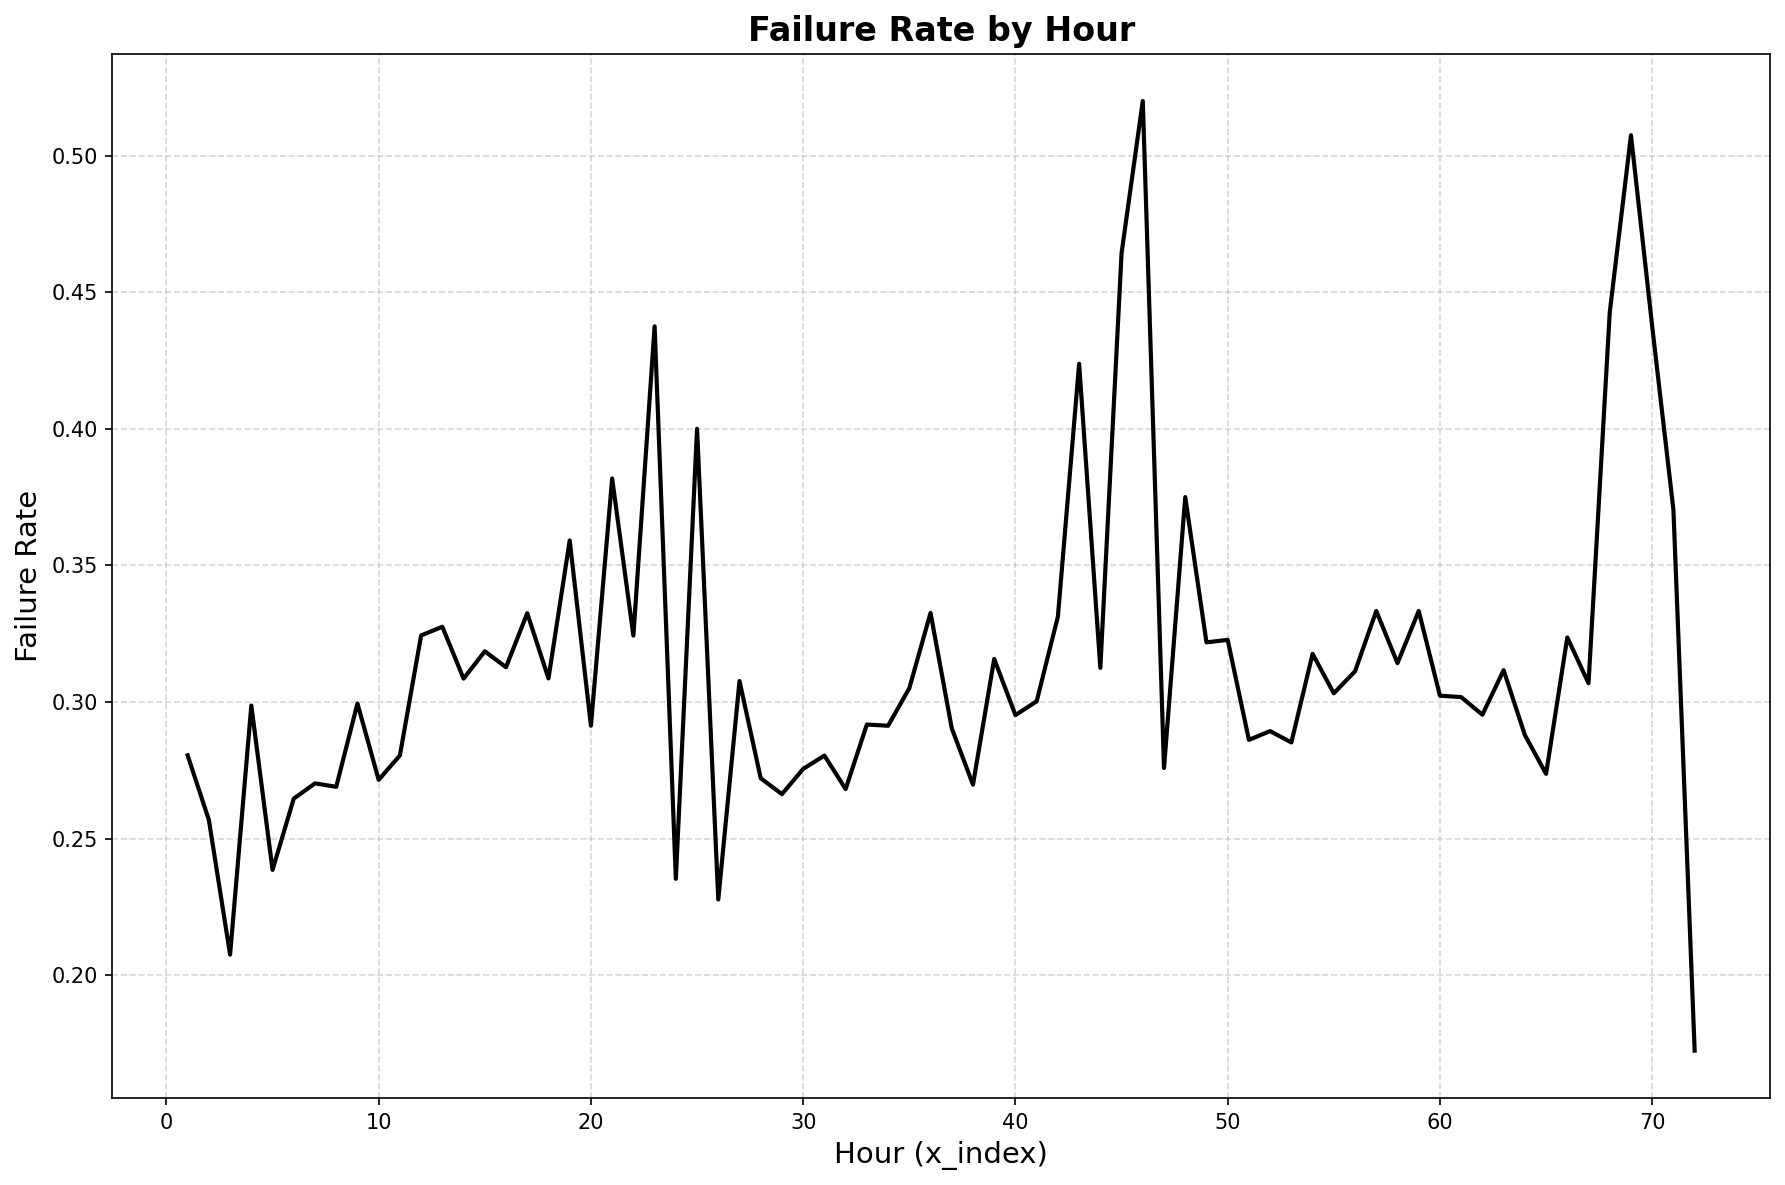

'Plotting for key: WALLET | PAYTM | notprovided'

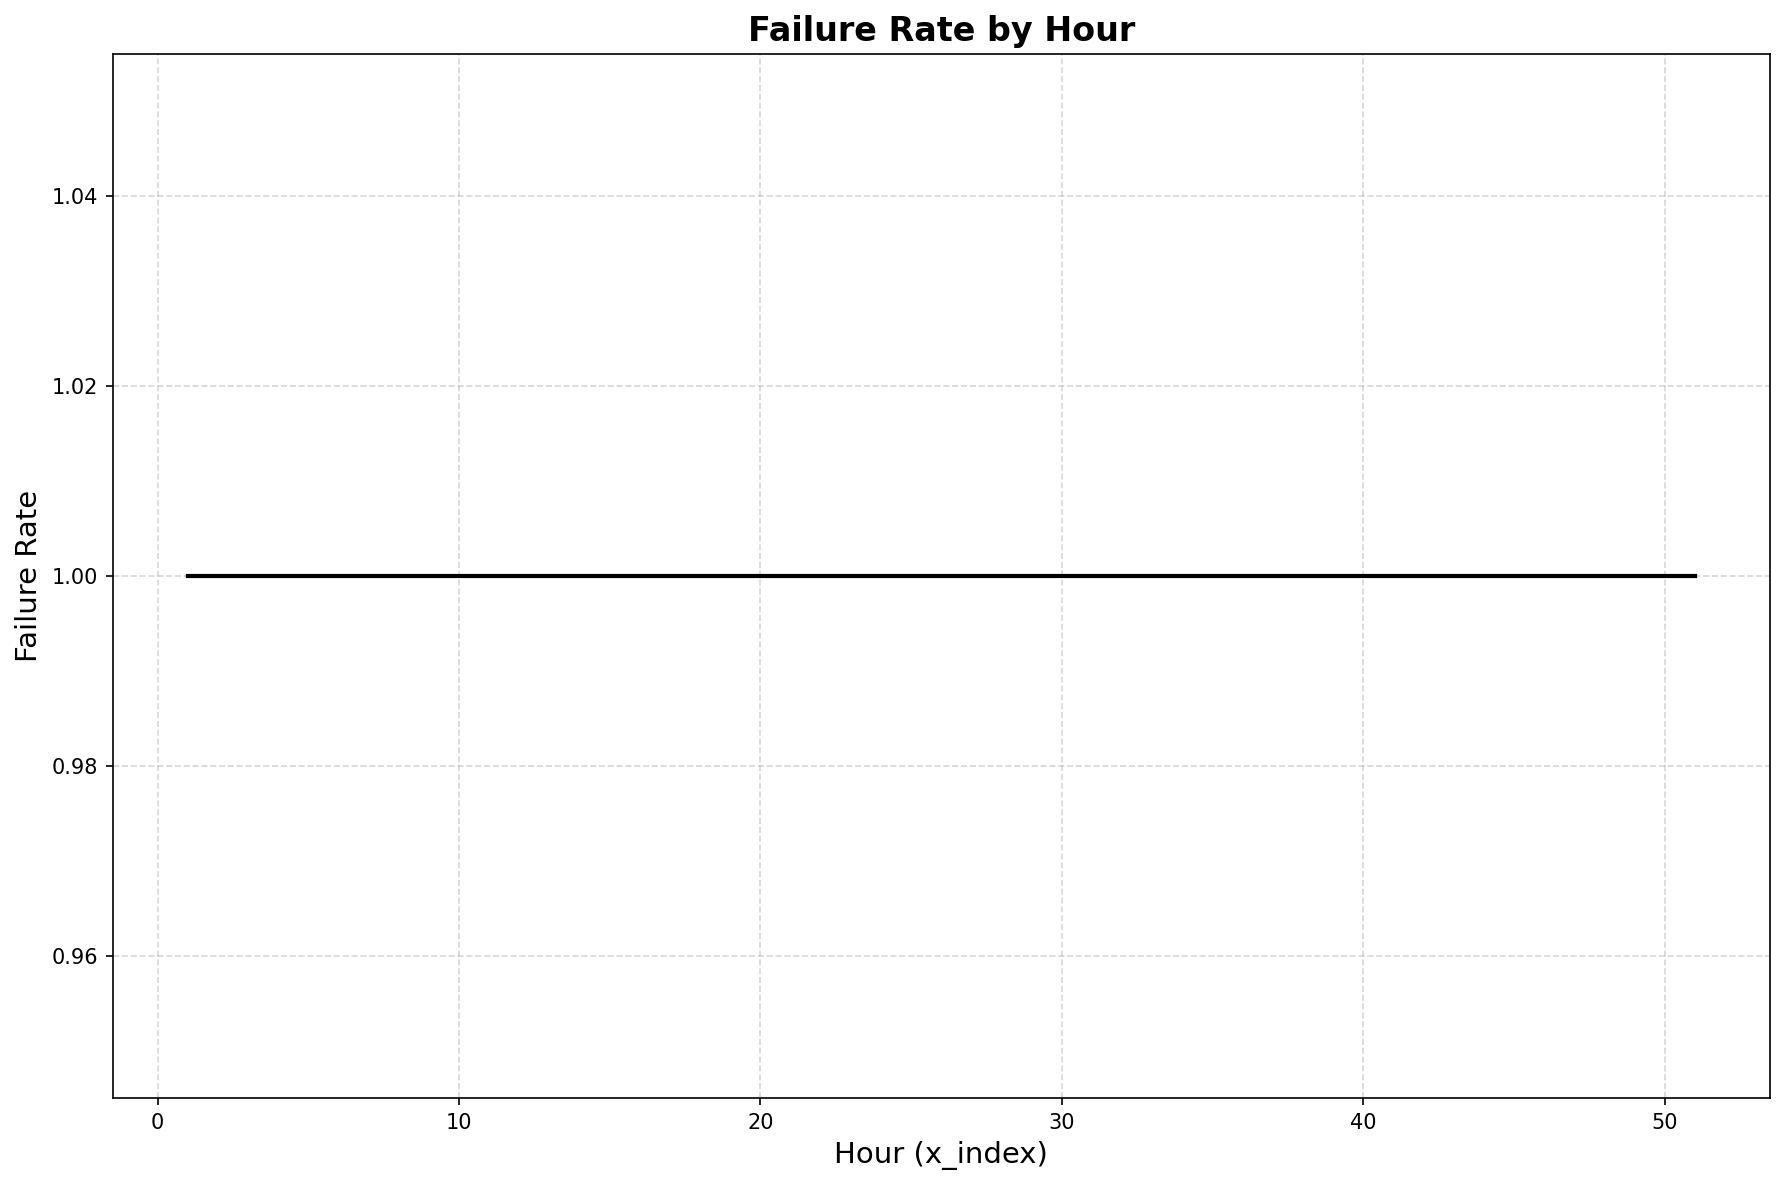

'Plotting for key: CARD | PAYTM | notprovided'

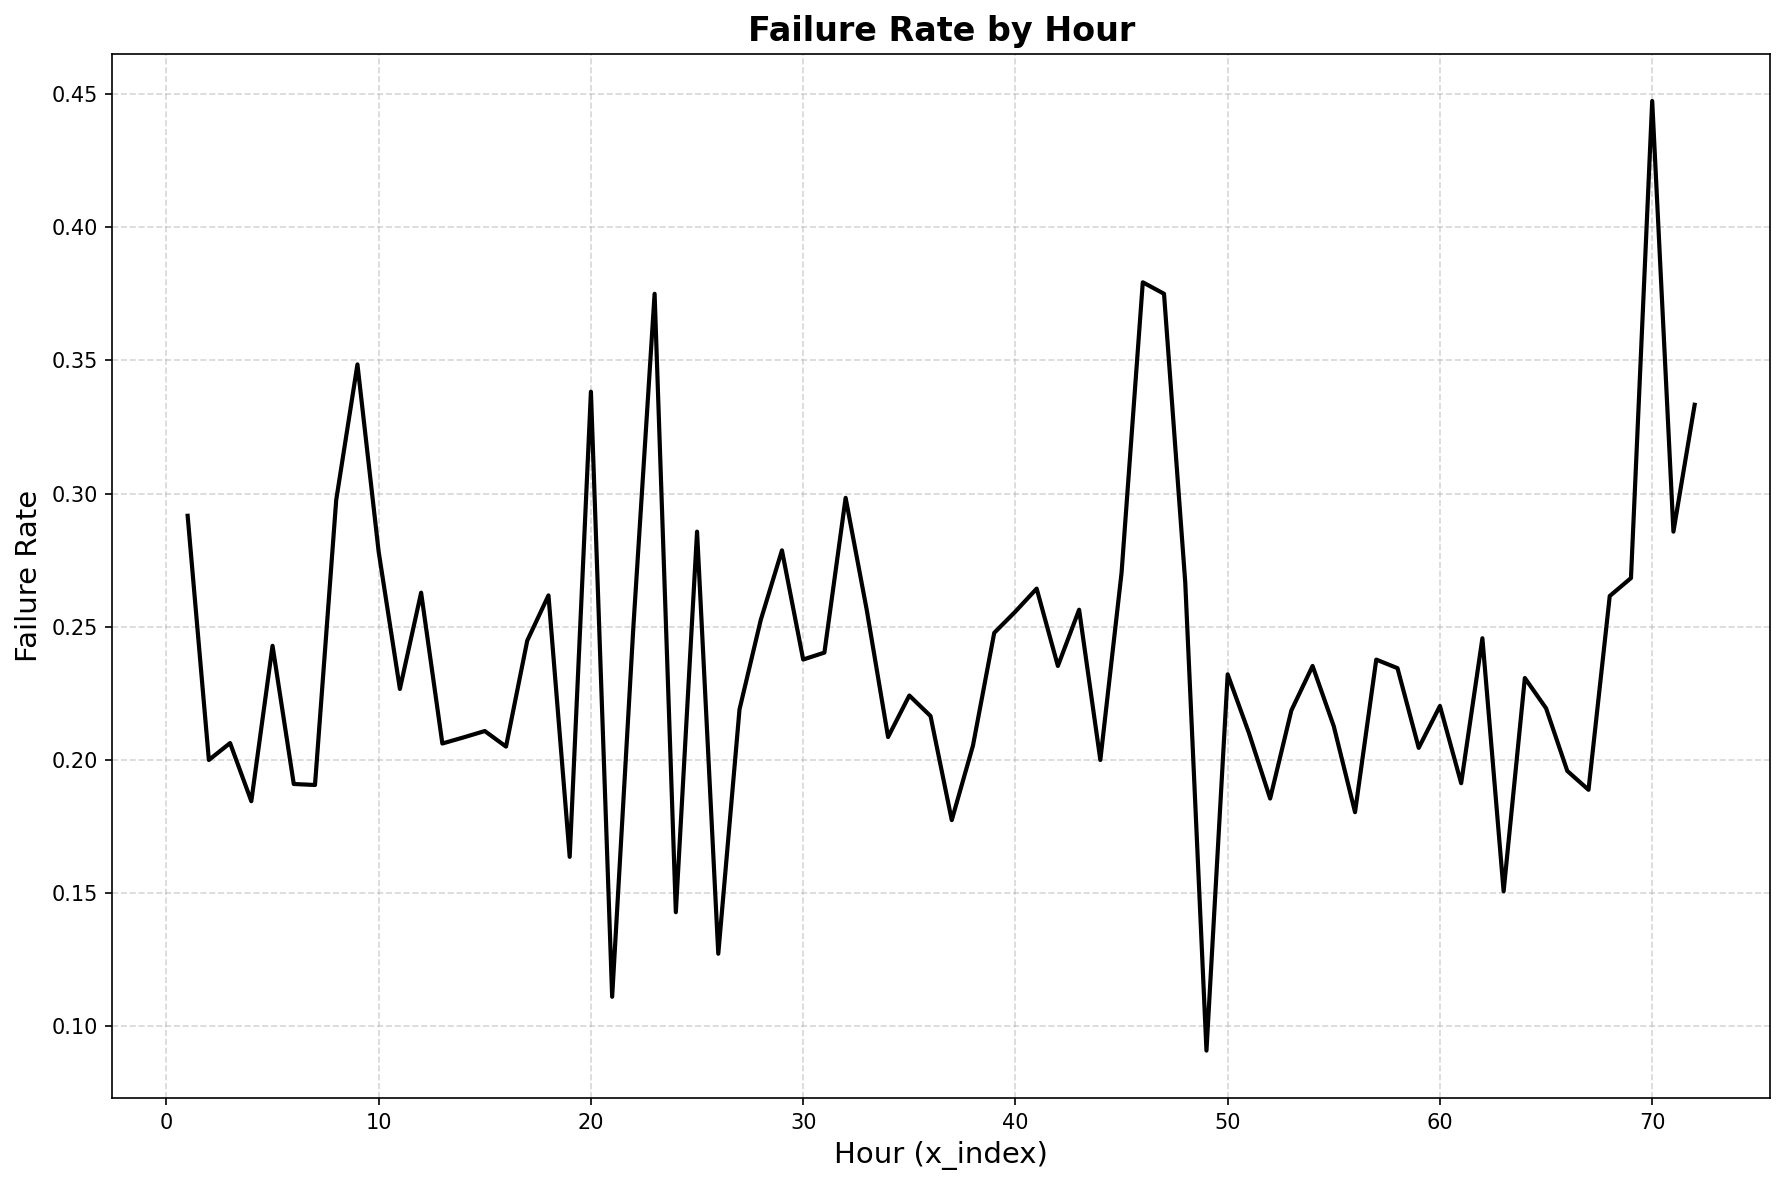

'Plotting for key: NB | PAYTM | notprovided'

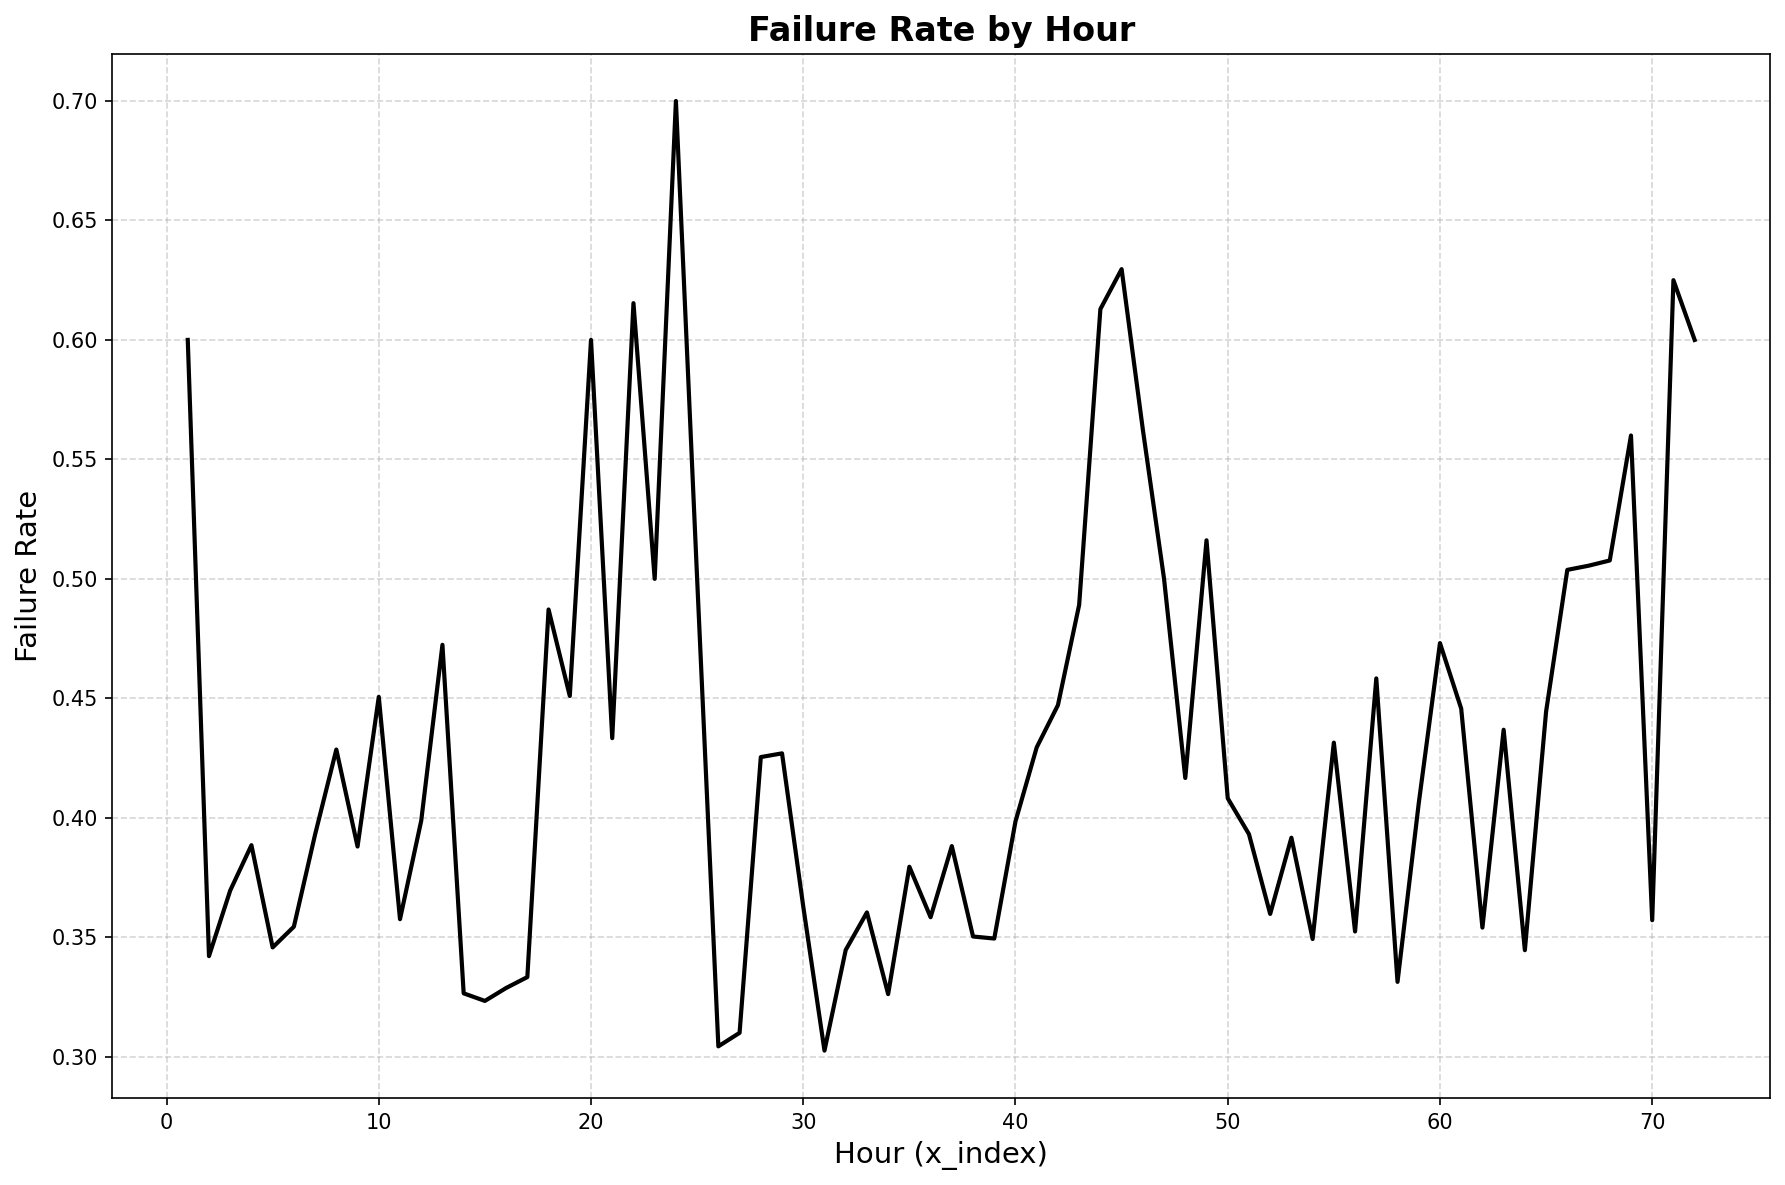

In [253]:
payment_methods = transactions['pmt'].unique()
subtypes = transactions['subtype'].unique()
filter_values = ["PAYTM", "PAYTM_V2", "PAYTM_UPI"]

subset_dict = {}

for pmt in payment_methods:
    for st in subtypes:
        for fv in filter_values:
            subset_name = f"{pmt} | {fv} | {st}"  
            subset_data = transactions[
                (transactions['pmt'] == pmt) &
                (transactions['subtype'] == st) &
                (transactions['pg'] == fv)
            ]
            subset_dict[subset_name] = subset_data

display([key for key in subset_dict if not subset_dict[key].empty])

for key, subset in subset_dict.items():
    if not subset.empty:
        display(f"Plotting for key: {key}")
        plot_failure_rate(subset)

clearly, 'UPI | PAYTM_V2 | UPI_COLLECT' is the subset of the data where the problem is 

Which merchants were impacted by this anomaly?

for each merchant we will compair their transaction failure rate within the anamolous subset and outisde of the anamolous subset so that out comp

,Normal_FR,Anamoly_FR,difference
mid,,,
countrydelight,0.252698,0.379263,0.126565
drivezy,0.411502,0.491178,0.079676
fanfight,0.342188,0.583116,0.240928
medlife_prod,0.358883,0.396825,0.037943
pharmeasytech,0.329011,0.460784,0.131773
purplle.com,0.413492,0.519231,0.105739
urbanclap,0.315613,0.244635,-0.070978
zivame,0.360382,0.414913,0.054531


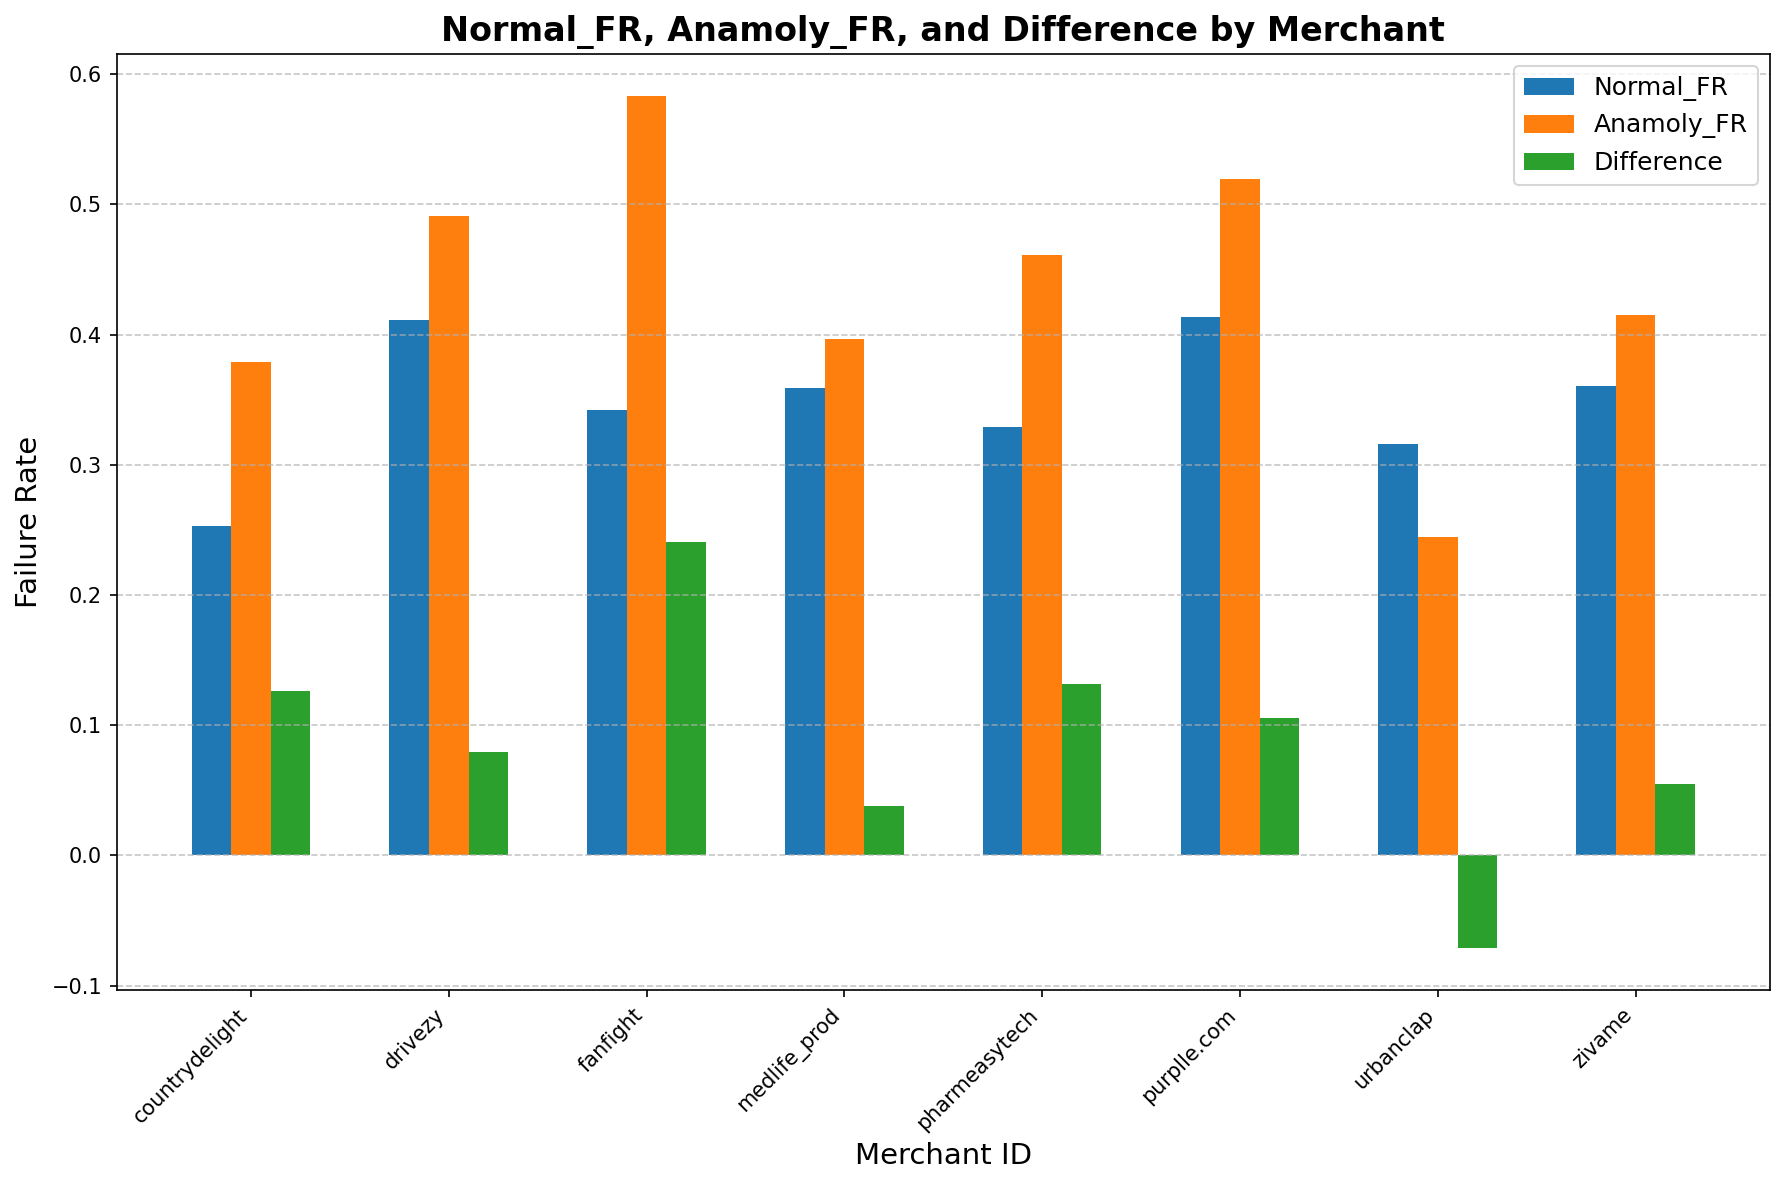

In [254]:
subset = transactions[
    (transactions['pmt'] == 'UPI') & 
    (transactions['pg'].isin(["PAYTM_V2"])) & 
    (transactions['subtype'] == 'UPI_COLLECT')
].copy() 

t_by_mid_anamoly = subset.groupby('mid')['t'].sum()
f_by_mid_anamoly = subset.groupby('mid')['failures'].sum()
rate_by_mid_anamoly = f_by_mid_anamoly/t_by_mid_anamoly

t_by_mid_whole = transactions.groupby('mid')['t'].sum()
f_by_mid_whole = transactions.groupby('mid')['failures'].sum()
rate_by_mid_whole = f_by_mid_whole/t_by_mid_whole

Merchants_Impacted = pd.DataFrame({
    'Normal_FR': rate_by_mid_whole,
    'Anamoly_FR': rate_by_mid_anamoly
})

Merchants_Impacted['difference'] = Merchants_Impacted['Anamoly_FR'] - Merchants_Impacted['Normal_FR']

display(Merchants_Impacted)


Merchants_Impacted.reset_index(inplace=True)  # Reset index to access 'mid' as a column
x = Merchants_Impacted['mid']  # Merchant IDs

# Define bar positions and width
bar_width = 0.2
x_indices = np.arange(len(x))

# Create the bar chart
plt.figure(figsize=(12, 8), dpi=150)
plt.bar(x_indices - bar_width, Merchants_Impacted['Normal_FR'], width=bar_width, label='Normal_FR')
plt.bar(x_indices, Merchants_Impacted['Anamoly_FR'], width=bar_width, label='Anamoly_FR')
plt.bar(x_indices + bar_width, Merchants_Impacted['difference'], width=bar_width, label='Difference')

# Add labels, title, and legend
plt.xticks(x_indices, x, rotation=45, ha='right')  # Add merchant IDs as x-ticks
plt.xlabel('Merchant ID', fontsize=14)
plt.ylabel('Failure Rate', fontsize=14)
plt.title('Normal_FR, Anamoly_FR, and Difference by Merchant', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


compair normal data and anamoly data to determine if the anamoly event could had been anticipated 

,failure_rate,x_index
0,0.327674,1
1,0.314521,2
2,0.264387,3
3,0.305846,4
4,0.323609,5
...,...,...
67,0.373403,68
68,0.409496,69
69,0.411290,70
70,0.359447,71


,failure_rate,x_index
0,0.230769,1
1,0.311475,2
2,0.274074,3
3,0.335294,4
4,0.371179,5
...,...,...
67,0.340000,68
68,0.293103,69
69,0.111111,70
70,0.153846,71


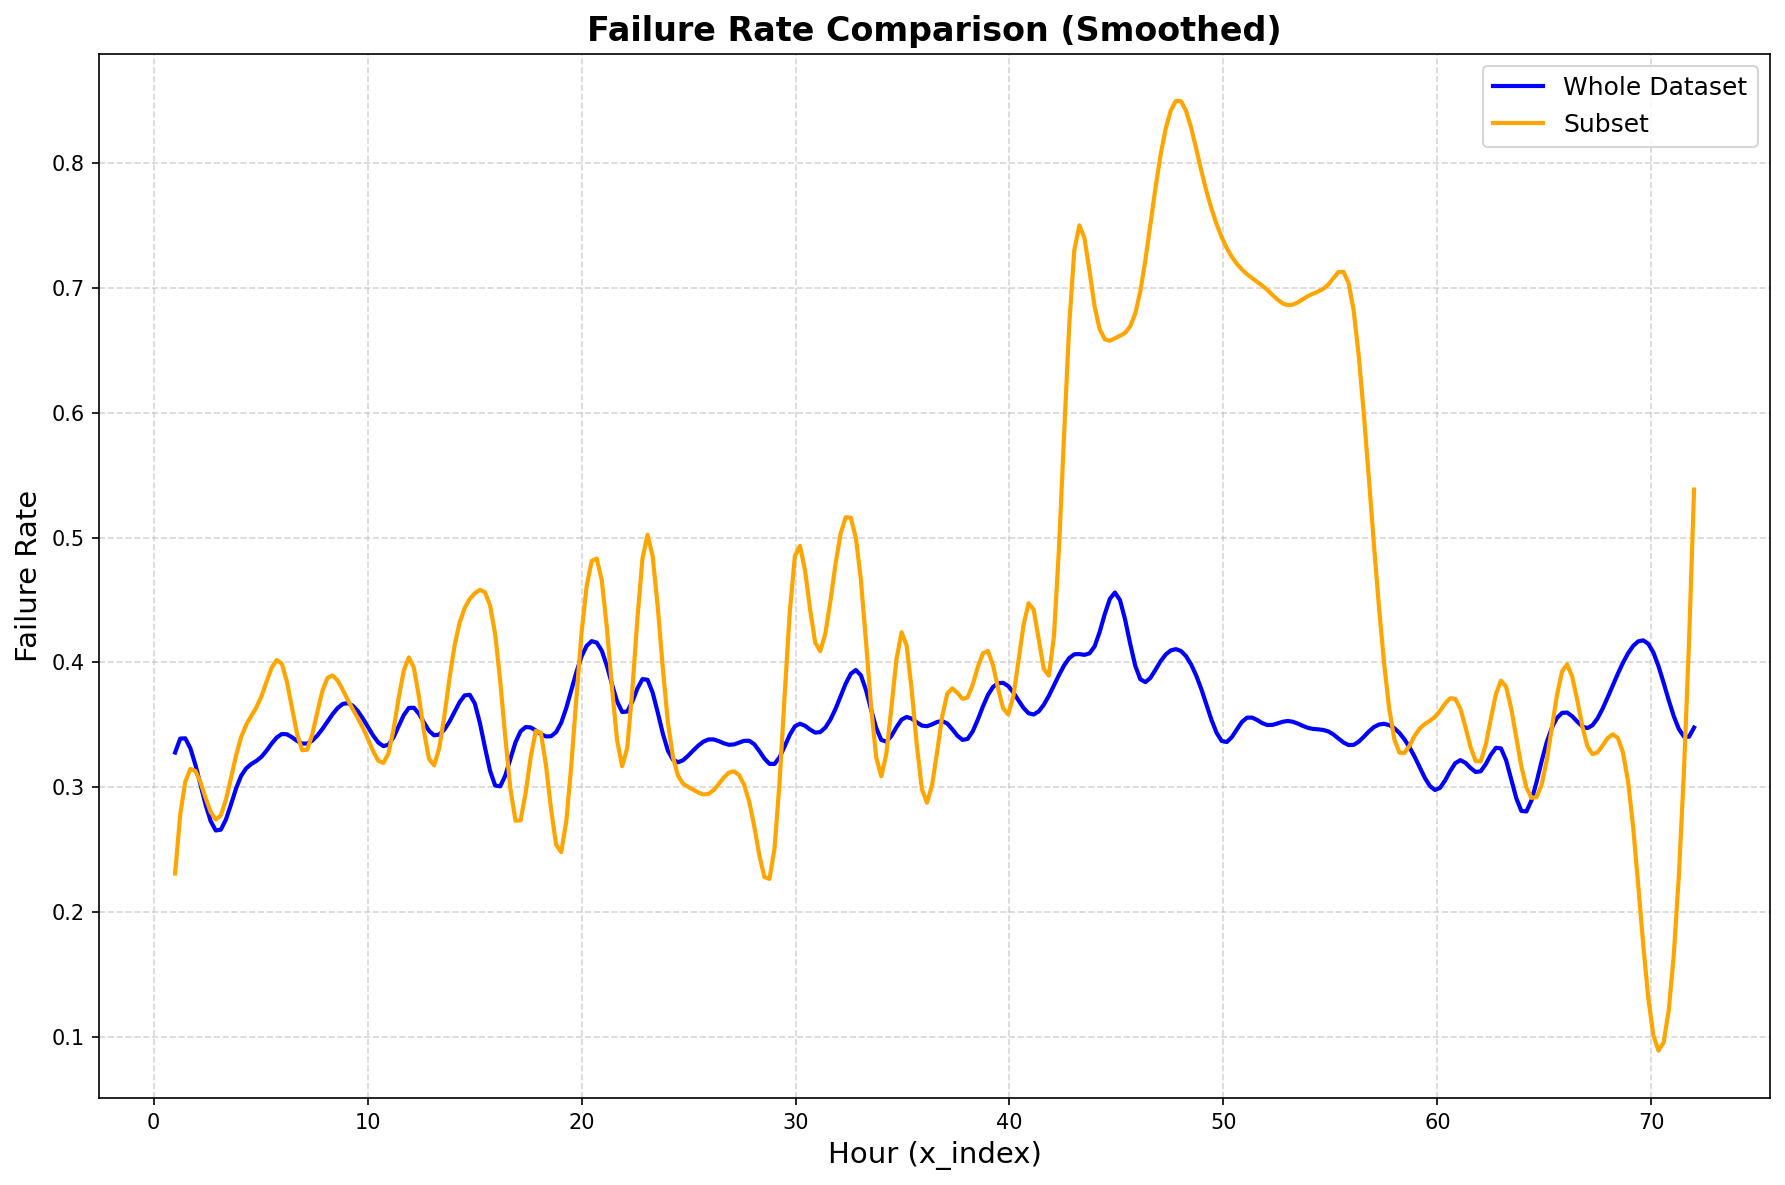

In [264]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline


subset = transactions[
    (transactions['pmt'] == 'UPI') & 
    (transactions['pg'] == 'PAYTM_V2') & 
    (transactions['subtype'] == 'UPI_COLLECT')
].copy()


compliment = transactions[
    ~((transactions['pmt'] == 'UPI') & 
    (transactions['pg'] == 'PAYTM_V2') & 
    (transactions['subtype'] == 'UPI_COLLECT'))
].copy()


def failure_rate_data(dataframe):
    unique_hours = sorted(dataframe['hr'].unique())

    t_by_hour = dataframe.groupby('hr')['t'].sum()
    s_by_hour = dataframe.groupby('hr')['s'].sum()

    failure_count = t_by_hour - s_by_hour
    failure_rate = failure_count / t_by_hour

    plot_data = pd.DataFrame({
        'failure_rate': failure_rate.values,
        'x_index': np.arange(1, len(unique_hours) + 1)
    })
    return plot_data

whole_plot_data = failure_rate_data(transactions)

subset_plot_data = failure_rate_data(subset)


display(whole_plot_data)

display(subset_plot_data)



import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import numpy as np

# Function to smooth the data
def smooth_line(x, y, num_points=300):
    """Smooth data using cubic spline interpolation."""
    x_smooth = np.linspace(min(x), max(x), num_points)
    spline = make_interp_spline(x, y, k=3)  # Cubic spline
    y_smooth = spline(x_smooth)
    return x_smooth, y_smooth

# Prepare the data for smoothing
x_whole = whole_plot_data['x_index']
y_whole = whole_plot_data['failure_rate']

x_subset = subset_plot_data['x_index']
y_subset = subset_plot_data['failure_rate']

# Smooth the data
x_whole_smooth, y_whole_smooth = smooth_line(x_whole, y_whole)
x_subset_smooth, y_subset_smooth = smooth_line(x_subset, y_subset)

# Plot the data
plt.figure(figsize=(12, 8), dpi=150)

# Whole dataset plot
plt.plot(x_whole_smooth, y_whole_smooth, label='Whole Dataset', color='blue', linewidth=2)

# Subset plot
plt.plot(x_subset_smooth, y_subset_smooth, label='Subset', color='orange', linewidth=2)

# Add title, labels, legend, and grid
plt.title("Failure Rate Comparison (Smoothed)", fontsize=16, fontweight='bold')
plt.xlabel("Hour (x_index)", fontsize=14)
plt.ylabel("Failure Rate", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.tight_layout()
plt.show()

ok yeah that's as much of this project that's worth re-doing in python for the sake of learing it, the rest of this is just plotting 